In [88]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [89]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 510)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())

np.save("../data/npy/toy1_test",scaled_Phi.T)

data_path = '../data/npy/toy1_test.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [90]:
print(np.shape(scaled_Phi))

(127, 127, 510)


In [91]:
phi_tot=tf.expand_dims(scaled_Phi.T, axis=3)
new_phi = phi_tot[:500]
print(np.shape(new_phi))
phi_test = phi_tot[500:]

(500, 127, 127, 1)


In [95]:

y = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([500  64  64   1], shape=(4,), dtype=int32)


In [96]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, y,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True),
            verbose=2)

    return history



In [97]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(64,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((64, 64, 1)),
    # tf.keras.layers.UpSampling2D((2,2)),
    # tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(127,127,1))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) #+ NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 127, 127, 1)]     0         
                                                                 
 average_pooling2d_39 (Avera  (None, 64, 64, 1)        0         
 gePooling2D)                                                    
                                                                 
 sequential_32 (Sequential)  (None, 64, 64, 1)         2400      
                                                                 
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 - 2s - loss: 0.2651 - mean_absolute_error: 0.4770 - val_loss: 0.3532 - val_mean_absolute_error: 0.5942 - 2s/epoch - 136ms/step
Epoch 2/500
15/15 - 0s - loss: 0.2111 - mean_absolute_error: 0.4340 - val_loss: 0.2781 - val_mean_absolute_er

In [101]:
test_true = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(phi_test)
test_model = history.model.predict(phi_test)

1/1 [==============================] - 0s 27ms/step


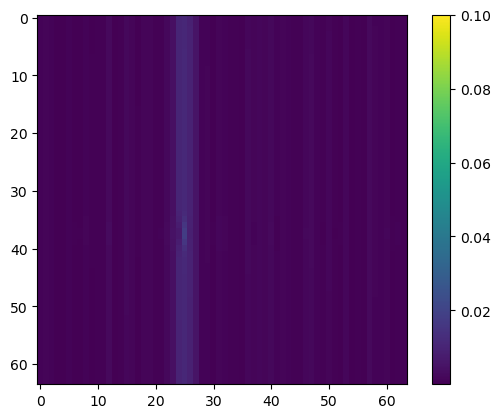

In [107]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]),vmax=0.1)
plt.colorbar()

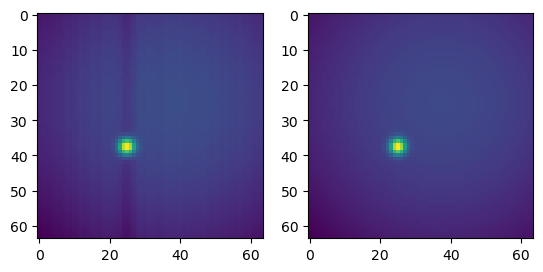

In [103]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_model[-1])
ax[1].imshow(test_true[-1])


In [104]:
print(test_model[-1])

[[[0.6535276 ]
  [0.65520394]
  [0.6559658 ]
  ...
  [0.6686763 ]
  [0.66867846]
  [0.66793364]]

 [[0.65444815]
  [0.65613276]
  [0.6569015 ]
  ...
  [0.66969186]
  [0.6696896 ]
  [0.6689402 ]]

 [[0.6553394 ]
  [0.6570321 ]
  [0.65780747]
  ...
  [0.6706754 ]
  [0.67066866]
  [0.66991526]]

 ...

 [[0.64164144]
  [0.64321077]
  [0.6438838 ]
  ...
  [0.6555615 ]
  [0.65562207]
  [0.6549331 ]]

 [[0.6404472 ]
  [0.6420056 ]
  [0.6426699 ]
  ...
  [0.6542438 ]
  [0.6543101 ]
  [0.6536271 ]]

 [[0.6395415 ]
  [0.6410917 ]
  [0.64174926]
  ...
  [0.65324455]
  [0.6533151 ]
  [0.65263647]]]
